# Colour Perception in Humans and Machines

In this notebook we compare the perceived similarity in colour for RetinaNet with that of Humans and the statistics of natural scenes. These plots correspond to Figure 5 from the paper.

**Note**: Unfortunately we can't share all the models for this experiment (due to file size restrictions) so the first two cells can't be run in colab.

## Our Models

In [57]:
''' Can't run in colab '''
import colorsys
import numpy as np
import torch
from training.model import BaselineModel 
from statistics.wavelength import wavelength_to_rgb

def response_to_wavelength(model, layer, wavelength):
    wavelength = torch.tensor([float(wavelength)], requires_grad=True)
    rgb = wavelength_to_rgb(wavelength, gamma=0.7)
    
    stimulus = torch.ones((1,32,32,3), requires_grad=False) * rgb
    stimulus = stimulus.permute(0, 3, 2, 1)
    
    model.forward_to_layer(stimulus, layer).mean().backward()

    return wavelength.grad, rgb


def compute_response_to_wavelengths(model, layer, inc=0.5, threshold=1e-4):
    responses = []

    step = 10
    for i in np.concatenate((np.arange(395, 645, step), [644])):
        base = response_to_wavelength(model, layer, i)
        responses.append(base[0])

    return np.array(responses)


def get_distances(model_dir=None, pretrained=True, cmode='colour'):
    distances = []
    
    for d_vvs in [1, 2, 3, 4]:
        for n_bn in [1, 2, 4, 8, 16, 32]:
            for t in range(4):
                n_ch = 1 if cmode == 'grey' else 3
                model = BaselineModel(n_bn, d_vvs, n_ch)

                if pretrained:
                    model.load_state_dict(torch.load(f'{model_dir}/model_{n_bn}_{d_vvs}_{t}.pt', map_location='cpu'))

                r = compute_response_to_wavelengths(model, f'ventral_relu{d_vvs - 1}')
                distances.append(r)

    distances = np.array(distances)
    return distances

distances = get_distances('../models/colour')
rand_distances = get_distances(pretrained=False)

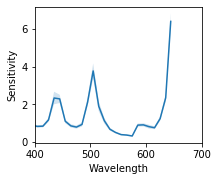

In [64]:
''' Can't run in colab '''
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(3,2.5))

sems = stats.sem(np.abs(distances) * 10000, axis=0)
means = (np.abs(distances) * 10000).mean(axis=0)

w = np.concatenate((np.arange(395, 645, 10), [644]))
plt.plot(w, means, linestyle='-')
plt.fill_between(w, means - sems, means + sems, alpha=0.2)

plt.xlim(400, 700)

plt.xlabel('Wavelength')
plt.ylabel('Sensitivity')
plt.savefig('figures/similarity_retinanet.pdf', bbox_inches='tight')

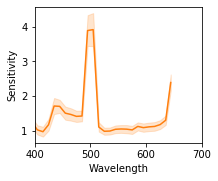

In [66]:
''' Can't run in colab '''
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(3,2.5))

sems = stats.sem(np.abs(rand_distances) * 10000, axis=0)
means = (np.abs(rand_distances) * 10000).mean(axis=0)

w = np.concatenate((np.arange(395, 645, 10), [644]))
plt.plot(w, means, linestyle='-', color='C1')
plt.fill_between(w, means - sems, means + sems, alpha=0.2, color='C1')

plt.xlim(400, 700)

plt.xlabel('Wavelength')
plt.ylabel('Sensitivity')
plt.savefig('figures/similarity_random.pdf', bbox_inches='tight')

## Load Dependencies - Colab Only

In [ ]:
from os.path import exists
if not exists('opponency.zip'):
    !wget -O opponency.zip https://github.com/ecs-vlc/opponency/archive/master.zip
    !unzip -qq opponency.zip
    !mv opponency-master/* ./
    !rm -r opponency-master

## Other Plots

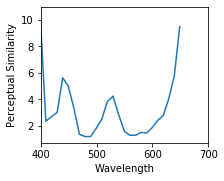

In [15]:
import pandas as pd
bedford = pd.read_csv('bedford1958.csv', names=['wavelength', 'sensitivity'], header=None)
bedford[bedford.wavelength.between(380, 650)].plot('wavelength', 'sensitivity', legend=False, figsize=(3,2.5), linestyle='-')

plt.xlim(400, 700)
plt.xlabel('Wavelength')
plt.ylabel('Perceptual Similarity')
plt.savefig('figures/similarity_bedford.pdf', bbox_inches='tight')

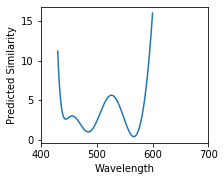

In [84]:
import pandas as pd

long = pd.read_csv('long2006.csv', names=['wavelength', 'sensitivity'], header=None)
# long = long[long.wavelength.between(420, 650)]  # .plot('wavelength', 'sensitivity')
# bedford
import numpy as np
p = np.poly1d(np.polyfit(long.wavelength, long.sensitivity, 8))
import matplotlib.pyplot as plt

x = np.linspace(430, 600, 1000)

plt.figure(figsize=(3,2.5))
plt.plot(x, p(x), linestyle='-')
plt.xlim(400, 700)
plt.xlabel('Wavelength')
plt.ylabel('Predicted Similarity')
plt.savefig('figures/similarity_long.pdf', bbox_inches='tight')